# Fingerprint Enhancement Tutorial and Feature Extraction and Matching

- Enhancement 
1. data load
2. segmenation
3. nomalize
4. estimate orientiaton
5. estimate frequency
6. enhancement with gaborfilter
7. bianrization
8. fingerprint_pipeline

- Feature Extraction
1. minutiae extract
2. minutiae filtering
3. find minutiae directions
4. make mcc   
  이 부분들은 아직 정리가 덜된 상태입니다.

- dataset에 따라 hyper paramatar들을 바꿔야 할 것입니다.
- 자세한 코드 설명은 따로 주석을 적어놓았으니 참고바랍니다.


## 1. Data Load

In [1]:
import os 
import glob
import cv2
import pickle
import natsort
import numpy as np
import sys
%matplotlib inline

In [2]:
lib_path = '.\\lib'
sys.path.insert(0,lib_path)

In [3]:
from lib.fingerprint_segmentation import *
from lib.utils import *
from lib.image_processing import *
from lib.fingerprint_enhancement_my import *
from lib.fingerprint_feature_extraction import *


In [4]:
#Data path 
#gt path
gt_path= './data/SOCOFing/Real/'
gt_file_path=[gt_path+i for i in os.listdir(gt_path)]
gt_file_path = natsort.natsorted(gt_file_path)


#altered path
altered_path = "./data/socofing/SOCOFing/Altered/"
img_type = ["Altered-Easy","Altered-Medium","Altered-Hard"]
noise_type= ["CR", "Obl","Zcut"]
file_type = ['path','images']

altered_images_dict = {}
gt_images_dict = {}
gt_images = []

#gt_images = [cv2.imread(i,cv2.IMREAD_GRAYSCALE)[2:-4,2:-4] for i in gt_file_path] #socofing dataset의 의미없는 padding 삭제

# for itype in img_type:
#     altered_images_dict[itype] = {}
#     for ntype in noise_type:
#         altered_images_dict[itype][ntype] = {}
#         img_path = os.path.join(altered_path, itype, '*_' + ntype + '.bmp')
#         file_list = glob.glob(img_path)
#         file_list = natsort.natsorted(file_list)
#         imgs_list = [cv2.imread(i,cv2.IMREAD_GRAYSCALE)[2:-4,2:-4] for i in file_list]
#         altered_images_dict[itype][ntype]['path'] = file_list
#         altered_images_dict[itype][ntype]['images']= imgs_list


# for itype in img_type:
#     gt_images_dict[itype] = {}
#     for ntype in noise_type:
#         gt_images_dict[itype][ntype] = {'path':[],'images':[]}
#         for altered_path in altered_images_dict[itype][ntype]['path']:
#             gt_file_name = altered_path.split('/')[-1].replace("_"+ntype,"").split('\\')[-1]
#             gt_fpath = os.path.join(gt_path, gt_file_name)
#             img = cv2.imread(gt_fpath,cv2.IMREAD_GRAYSCALE)[2:-4,2:-4]
#             gt_images_dict[itype][ntype]['path'].append(gt_fpath)
#             gt_images_dict[itype][ntype]['images'].append(img)

In [17]:
# with open("gt_dict.pkl", "wb") as f:
#     pickle.dump(gt_images_dict, f)
# with open ("altered_dict.pkl","wb") as f :
#     pickle.dump(altered_images_dict,f)
# with open("gt_images.pkl", "wb") as f:
#     pickle.dump(gt_images, f)

with open('./data/gt_images.pkl', 'rb') as f:
    gt_images = pickle.load(f)
# with open('gt_dict.pkl','rb') as f :
#     gt_dict = pickle.load(f)
with open('./data/altered_dict.pkl','rb') as f:
    altered_images_dict = pickle.load(f)

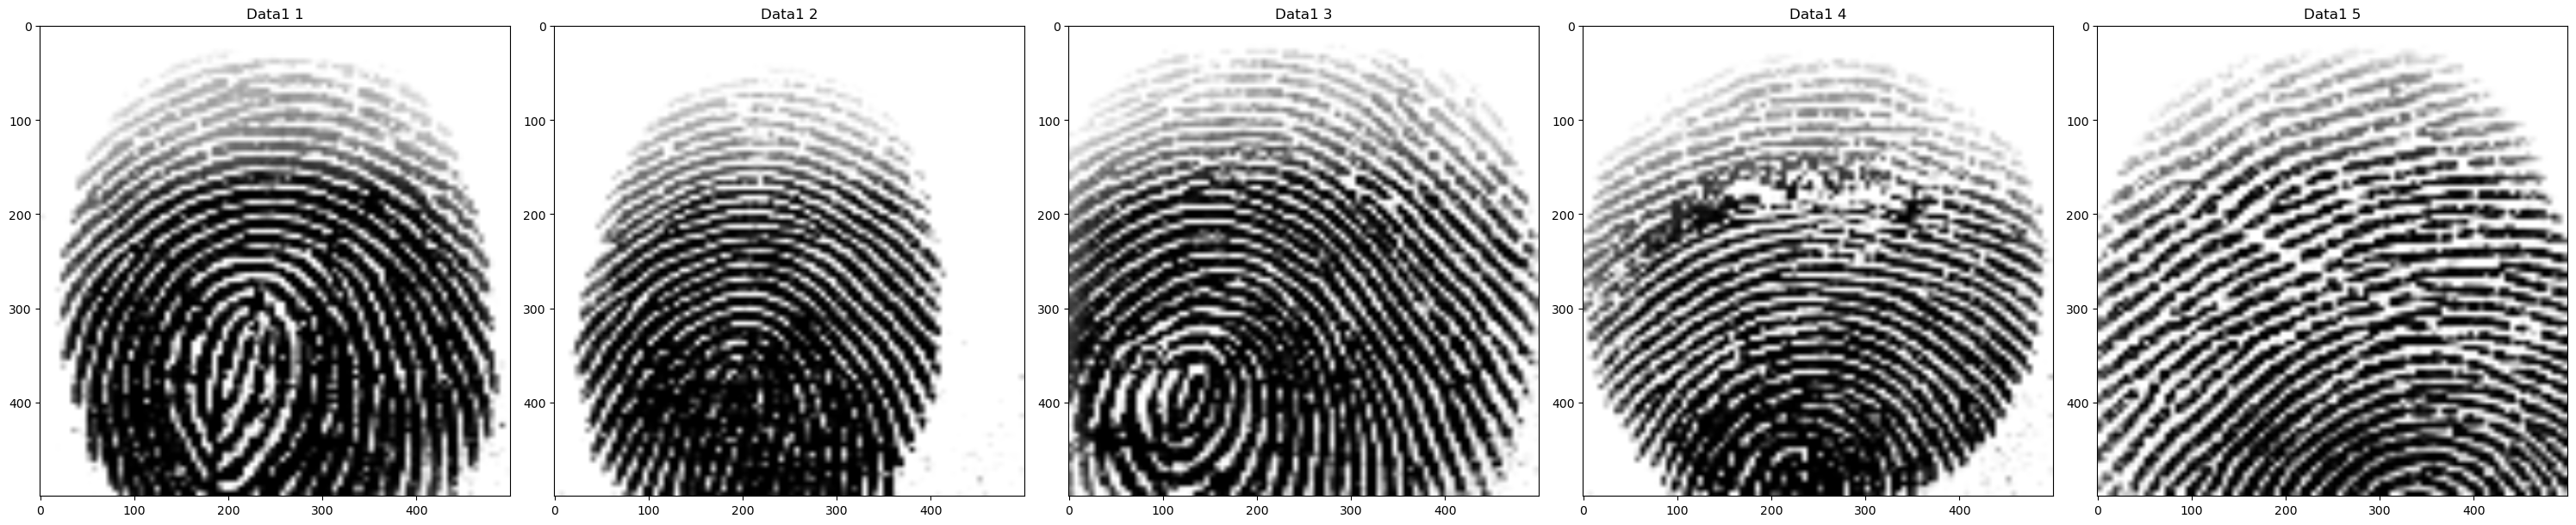

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5,figsize=(30,20))

for i, data in enumerate(gt_images[:5]):
    axes[i].imshow(data,cmap='gray')
    axes[i].set_title(f'Data1 {i+1}')

plt.tight_layout()
plt.show()

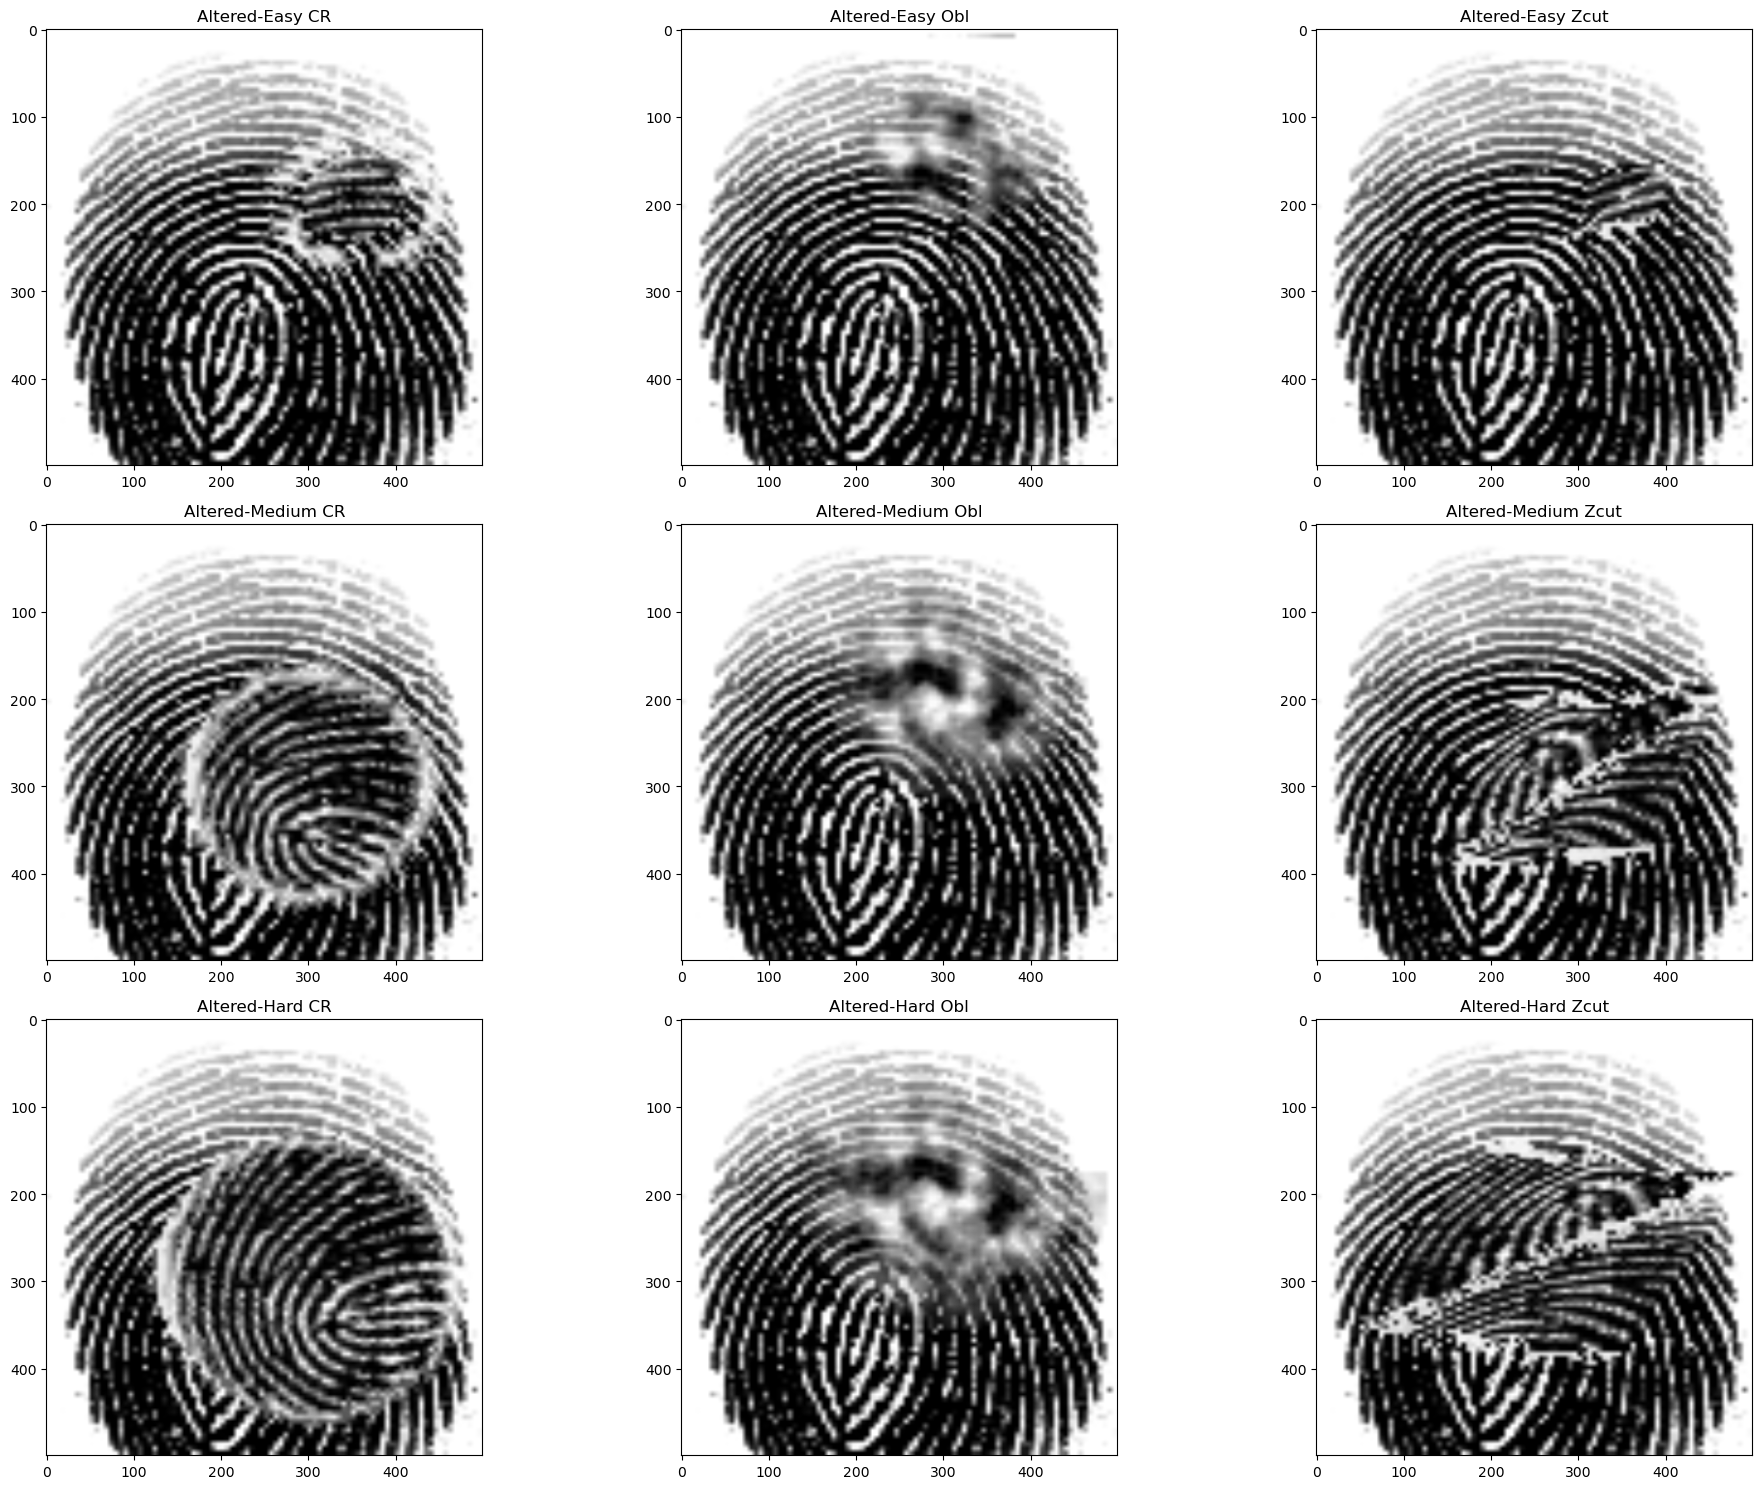

In [7]:

fig, axes = plt.subplots(3,3,figsize=(20,15))

for i,itype in enumerate(img_type) : 
    for j,ntype in enumerate(noise_type)  :
        img = altered_images_dict[itype][ntype]['images'][0] 
        axes[i][j].imshow(img,cmap='gray')
        axes[i][j].set_title(itype+' '+ntype)

plt.tight_layout()

In [8]:
# # Resolution (500,500)
# for itype in img_type :
#     for ntype in noise_type :
#         altered_images_dict[itype][ntype]['images'] = resize_images((altered_images_dict[itype][ntype]['images']),(500,500))
 
# for itype in img_type :
#     for ntype in noise_type :
#         gt_images_dict[itype][ntype]['images'] = resize_images((gt_images_dict[itype][ntype]['images']),(500,500))
 
# gt_images = resize_images(gt_images,(500,500))


## 2. Segmentation and normalization

https://postimg.cc/1fLJhdWK


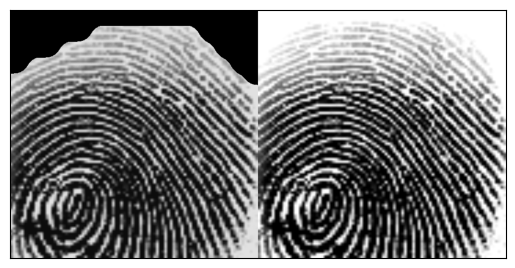

In [19]:
img = gt_images[2]
seg_img,mask = segmentation_maksed_thresholding(img,block=32)
norm_img = normalize_with_mask(seg_img,mask=mask)
display_image(np.hstack((norm_img,img)))

## 3. estimate orientaiton

(500, 500)


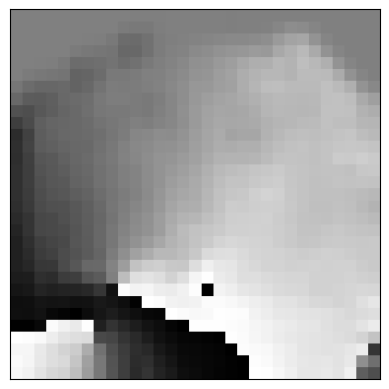

In [20]:
ori_img = estimate_orientation(norm_img,smooth_flag=True)
print(ori_img.shape)
display_image((ori_img))

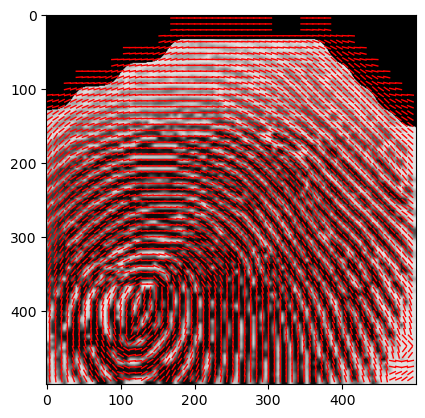

In [21]:
#matplotlib enhancemnet.py 모듈 충돌로 인해 따로 시각화 코드를 빼서 사용함
import matplotlib.pyplot as plt
def show_orientations(image:np.ndarray, orientations:np.ndarray, label:str, w:int=16, vmin:float=0.0, vmax:float=255.0):
    """
    args : 
        image : 방향성을 그릴 원본 이미지
        orientation : 방향성 이미지
        label : plt의 label
        w : orientation을 그리기 위한 블락 사이즈
        vmin : 이미지 pixel 최솟값
        vmax : 이미지 pxiel 최댓값
    description :
    orientation 이미지를 시각화 하기 위한 코드.
    cos과 sin 함수는 각각 x, y축 방향의 이동 거리를 계산하는 데 사용됩니다. 
    이 함수들은 특정 각도에 대한 cos과 sin 값을 반환하는데, 이때의 각도는 라디안(radian) 값으로 입력되어야 합니다.
    따라서 위 코드에서는 주어진 방향(orientation) 값으로부터 cos과 sin 값을 계산하고, 이를 이용하여 시작점과 끝점을 결정합니다. 
    시작점(cx, cy)에서 cos과 sin 값에 비례하는 거리(w0.5)만큼 x, y 방향으로 이동한 끝점을 구한 후, 두 점을 선으로 이어주는 plot 함수를 사용하여 해당 방향을 시각화합니다. 
    선의 길이 또한 조절 가능하지만 인자로 굳이 만들지는 않았습니다.
    """

    #orientation을 그릴 이미지 띄우기
    # plt.figure().suptitle(label)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)

    height, width = image.shape
    #블락만큼 돌면서 중심좌표를 구한 뒤 그에 맞는 방향성을 계산해 그린다.
    for y in range(0, height, w):
        for x in range(0, width, w):
            if np.any(orientations[y : y + w, x : x + w] == 0.0):
                continue

            cy = (y + min(y + w, height)) // 2
            cx = (x + min(x + w, width)) // 2
            if y+w//2 > height-1 or x+w//2 >width-1 :
                continue 
                
            orientation = orientations[y + w // 2, x + w // 2]
            plt.plot(
                [
                    cx - w * 0.5 * np.cos(orientation),
                    cx + w * 0.5 * np.cos(orientation),
                ],
                [
                    cy - w * 0.5 * np.sin(orientation),
                    cy + w * 0.5 * np.sin(orientation),
                ],
                "r-",
                lw=1.0,
            )

show_orientations(norm_img,ori_img,"orientation" ,8)

## 4. estimation freq
https://i.postimg.cc/HsNjDHYt/fingerprint-enhancemnet-algorithm-frequency-fig8.png

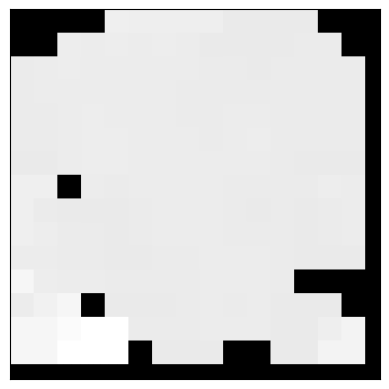

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [65]:
freq_img =estimate_frequencies(norm_img,ori_img,w=32)
display_image(freq_img*255)
print(freq_img)

## 5. enhancemnet fingerprint

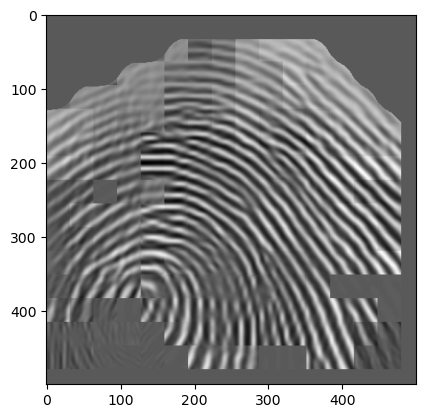

In [23]:

ehance_img= gaborFilter(img,ori_img,freq_img,w=32)
ehance_img = np.where(mask == 1.0, ehance_img,1.0)
plt.imshow(ehance_img)


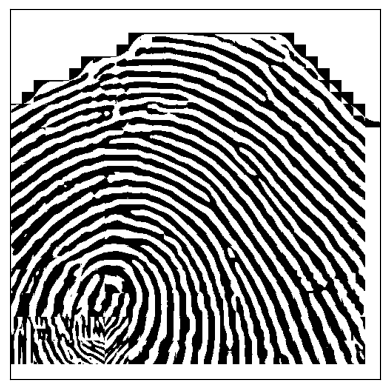

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


In [24]:
bi_img = binarize(ehance_img,max_val=255,min_val=0) 
display_image(bi_img)
print(bi_img)

## 6. Thinning (세선화)

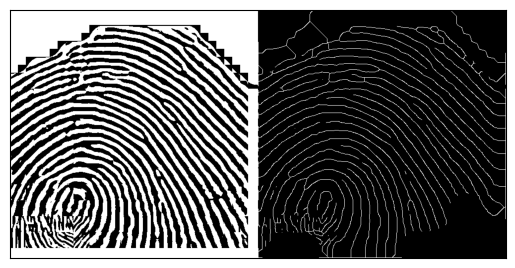

In [66]:

th_img = thinning_image(bi_img,mask)
display_image(np.hstack((bi_img,th_img)))

## Fingerprint Enhancement Pipeline

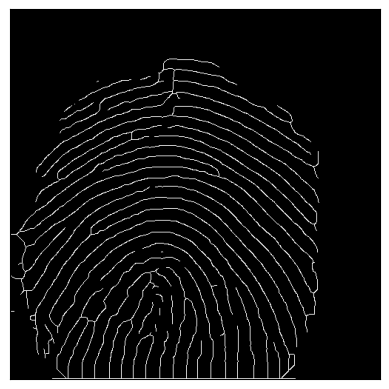

In [37]:
#reference : Davide Maltoni, Dario Maio, Anil K. Jain, Jianjiang Feng - Handbook of Fingerprint Recognition-Springer (2022)
test,_ = fingerprint_pipeline(gt_images[1])
display_image(test)

In [30]:
#test_set
thinning_gt_images =[]
thinning_gt_seg = []
for img in gt_images[:30]:
    th_img, mask = fingerprint_pipeline(img)
    thinning_gt_seg.append(mask)
    thinning_gt_images.append(th_img)

# Feature Extraction
https://postimg.cc/G4bXy44V

- 지문이미지에서의 Minutiae라는 것은 개개인의 지문의 고유 특징들을 망라해서 이야기하는 것입니다.
- Crossing number라는 algorithm을 통하여 지문의 끝점(ridge ending or teminations)과 지문의 분기점 bifurcation을 찾을것입니다.

### Feature Extraction


Cross Number 

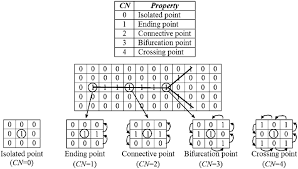
- 쉽게 이야기해서 픽셀주변을 둘러보고 1이면 끝점 3이면 분기점이란 이야기이다.
$$ cn(v) = \sum_{i=0}^7 \begin{cases}
    1 & \text{if } v[i] < v[(i+1) \mod 8] \\
    0 & \text{otherwise}
\end{cases} $$

In [52]:
finger_print = gt_images[0]
skeleton1 = thinning_gt_images[0]
skeleton2 = thinning_gt_images[1]
minutiae,  terminations,biufurcations = minutiae_extraction(skeleton1)
minutiae2, terminations2,biufurcations2 = minutiae_extraction(skeleton2)


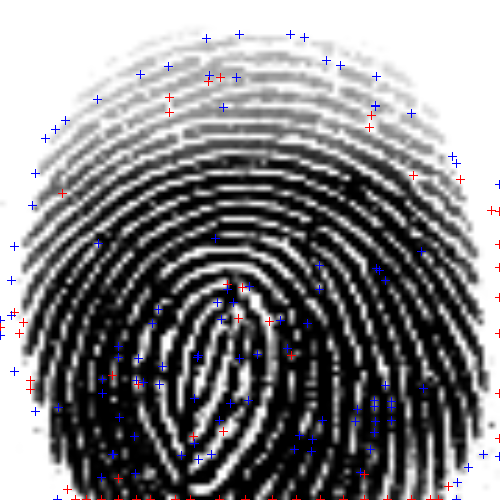
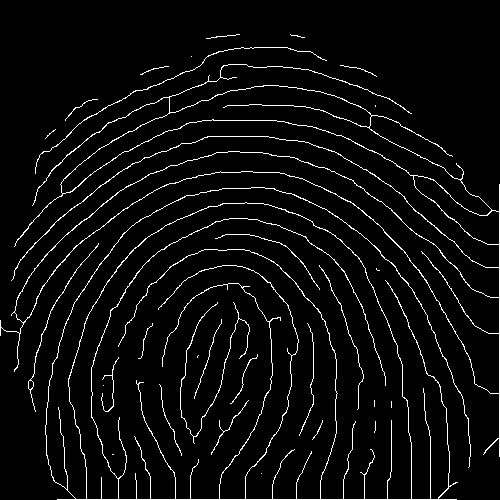
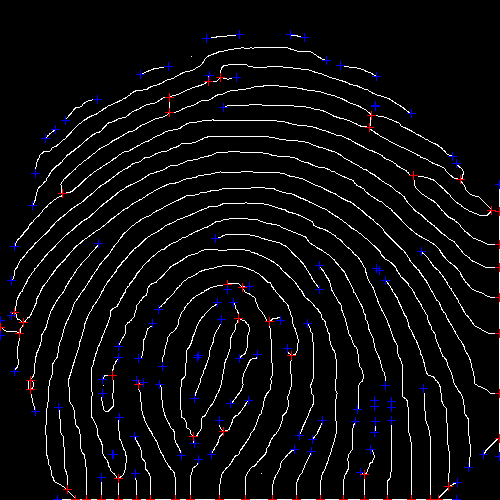

In [53]:
# crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation3
#[(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))] 
# zip(*np.where(np.isin(cn, [1,3])))의 결과를 언패킹하여 y와 x 변수에 할당하고, list comprehension를 사용하여 (x,y,cn[y,x]==1) 형태의 튜플을 요소로 갖는 리스트를 생성합니다. 
# minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]
# print(minutiae)
show(draw_minutiae(finger_print, minutiae), skeleton1, draw_minutiae(skeleton1, minutiae))



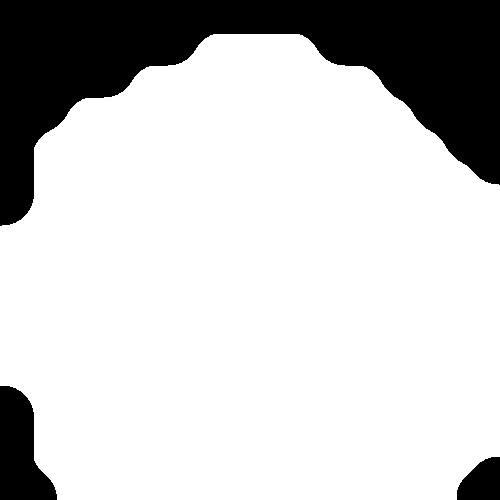
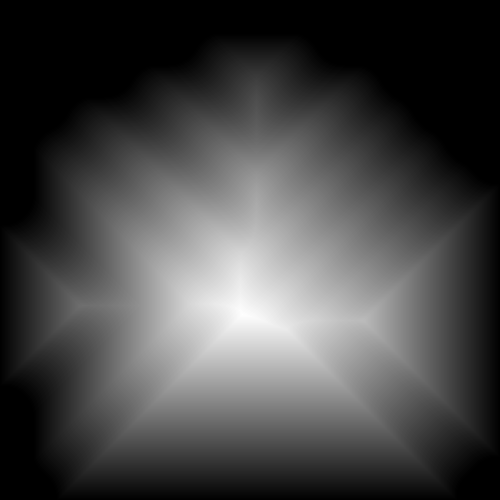

In [54]:
filterd_minutiae,mask_distance = filtering_minutiae(minutiae,thinning_gt_seg[0])
filterd_minutiae2,mask_distance2 = filtering_minutiae(minutiae2,thinning_gt_seg[1])

show(thinning_gt_seg[0]*255, mask_distance)


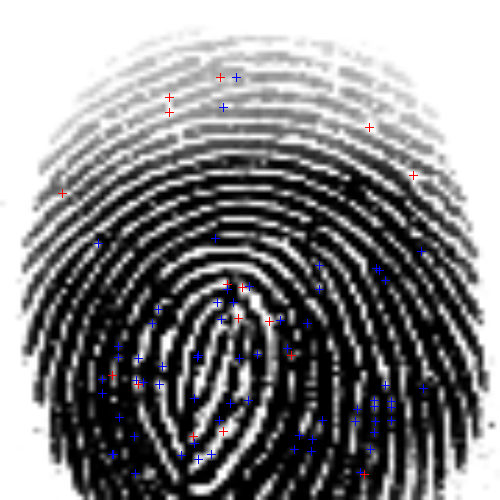
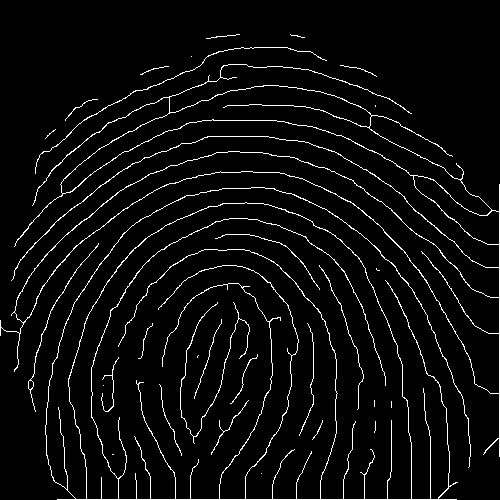
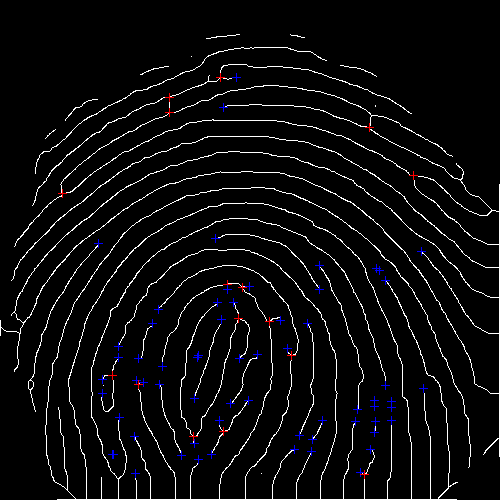

In [56]:
filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>25, minutiae))
show(draw_minutiae(finger_print, filtered_minutiae), skeleton1, draw_minutiae(skeleton1, filtered_minutiae))

# Step 6: Estimation of minutiae directions
- 이 부분부터는 reference는 찾았지만 이해를 덜한 부분입니다.
- 지문 특징점의 방향성을 찾고 그것을 통해 이후 mcc라는 기법을 사용하여 지문의 templete을 만들어 지문을 인증할때 indexing으로도 활용되고 매칭으로도 활용가능합니다.
- Minutia Cylinder-Code A New Representation and Matching Technique for Fingerprint Recognition Raffaele Cappelli, Member, IEEE, Matteo Ferrara, and Davide Maltoni, Member, IEEE

In [58]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

skeleton01 = np.where(skeleton1!=0, 1, 0).astype(np.uint8)
# Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
cn_values = cv2.filter2D(skeleton01, -1, cn_filter, borderType = cv2.BORDER_CONSTANT)

cn = cv2.LUT(cn_values, cn_lut)
# Keep only crossing numbers on the skeleton
cn[skeleton1==0] = 0

def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

# LUT: for each 8-neighborhood and each previous direction [0,8], 
#      where 8 means "none", provides the list of possible directions
nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

def follow_ridge_and_compute_angle(x, y, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None



valid_minutiae = []
for x, y, term in filtered_minutiae:
    d = None
    if term: # termination: simply follow and compute the direction        
        d = follow_ridge_and_compute_angle(x, y)
    else: # bifurcation: follow each of the three branches
        dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
        if len(dirs)==3: # only if there are exactly three branches
            angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
            if all(a is not None for a in angles):
                a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                d = angle_mean(a1, a2)                
    if d is not None:
        valid_minutiae.append( (x, y, term, d) )


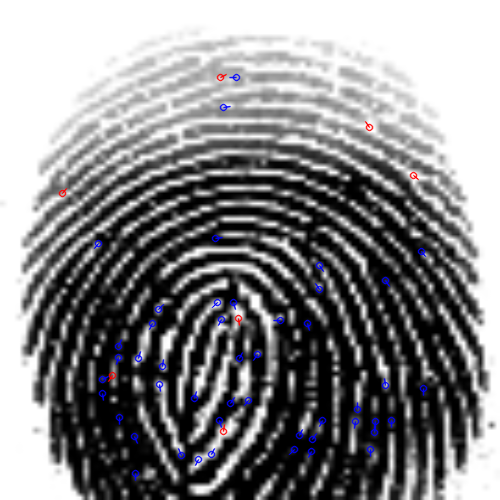

In [59]:
show(draw_minutiae(finger_print, valid_minutiae))

## genrate mcc 
- 아직 분석이 안끝났습니다..

In [60]:
# Compute the cell coordinates of a generic local structure
mcc_radius = 70
mcc_size = 16

g = 2 * mcc_radius / mcc_size
x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
y = x[..., np.newaxis]
iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
ref_cell_coords = np.column_stack((x[ix], x[iy]))

In [61]:
# Compute the cell coordinates of a generic local structure
mcc_radius = 70
mcc_size = 16

g = 2 * mcc_radius / mcc_size
x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
y = x[..., np.newaxis]
iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
ref_cell_coords = np.column_stack((x[ix], x[iy]))

mcc_sigma_s = 7.0
mcc_tau_psi = 400.0
mcc_mu_psi = 1e-2

def Gs(t_sqr):
    """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
    return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

def Psi(v):
    """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
    return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))


# n: number of minutiae
# c: number of cells in a local structure

xyd = np.array([(x,y,d) for x,y,_,d in valid_minutiae]) # matrix with all minutiae coordinates and directions (n x 3)

# rot: n x 2 x 2 (rotation matrix for each minutia)
d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

# rot@ref_cell_coords.T : n x 2 x c
# xy : n x 2
xy = xyd[:,:2]
# cell_coords: n x c x 2 (cell coordinates for each local structure)
cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

# cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
# xy                                 : (1 x 1) x n x 2
# cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
# dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

# cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
cs = Gs(dists)
diag_indices = np.arange(cs.shape[0])
cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

# local_structures : n x c (cell values for each local structure)
local_structures = Psi(np.sum(cs, -1))

In [62]:
from ipywidgets import interact
fingerprint = gt_images[0]
fignerprint2 = gt_images[2]
@interact(i=(0,len(valid_minutiae)-1))
def test(i=0):
    show(draw_minutiae_and_cylinder(gt_images[0], ref_cell_coords, valid_minutiae, local_structures, i))

interactive(children=(IntSlider(value=0, description='i', max=53), Output()), _dom_classes=('widget-interact',…

## Fingerprint Matching use MCC

In [42]:
print(f"""Fingerprint image: {fingerprint.shape[1]}x{fingerprint.shape[0]} pixels
Minutiae: {len(valid_minutiae)}
Local structures: {local_structures.shape}""")

Fingerprint image: 500x500 pixels
Minutiae: 76
Local structures: (76, 208)


In [43]:
f1, m1, ls1 = fingerprint, valid_minutiae, local_structures